In [1]:
import os
import numpy as np
import time
import sagemaker
from sagemaker.session import s3_input
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, rule_configs
from sagemaker.tensorflow import TensorFlow

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

bucket_name = 'sagemaker-jobs'
job_folder = 'jobs'
dataset_folder = 'datasets'

In [2]:
# !pip install -q --upgrade pip
# !pip install -q sagemaker smdebug awscli sagemaker-experiments --upgrade

In [3]:
hyperparams={    'epochs'       : 200,
                 'learning-rate': 0.01,
                 'batch-size'   : 256,
                 'weight-decay' : 2e-4,
                 'momentum'     : 0.9,
                 'optimizer'    : 'adam'}

In [4]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()), 
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.overfit())
]

In [5]:
job_name = f'tensorflow-debugger-{time.strftime("%Y-%m-%d-%H-%M-%S-%j", time.gmtime())}'
output_path = f's3://{bucket_name}/jobs'

metric_definitions = [{'Name': 'val_acc', 'Regex': 'val_acc: ([0-9\\.]+)'}]
train_instance_type = 'ml.p3.2xlarge'
#train_instance_type = 'local_gpu'

tf_estimator = TensorFlow(entry_point          = 'cifar10-training-sagemaker.py', 
                          source_dir           = 'code',
                          output_path          = output_path + '/',
                          code_location        = output_path,
                          role                 = role,
                          train_instance_count = 1, 
                          train_instance_type  = train_instance_type,
                          framework_version    = '1.14', 
                          py_version           = 'py3',
                          script_mode          = True,
                          metric_definitions   = metric_definitions,
                          hyperparameters      = hyperparams,
                          rules                = rules)

if train_instance_type == 'local_gpu':
    train_path = 'file://../dataset/train'
    val_path = 'file://../dataset/validation'
    eval_path = 'file://../dataset/eval'
else:
    train_path = f's3://{bucket_name}/{dataset_folder}/cifar10-dataset/train'
    val_path = f's3://{bucket_name}/{dataset_folder}/cifar10-dataset/validation'
    eval_path = f's3://{bucket_name}/{dataset_folder}/cifar10-dataset/eval'

In [6]:
tf_estimator.fit({'training': train_path,
                  'validation': val_path,
                  'eval': eval_path},
                  job_name=job_name, wait=False)

In [7]:
job_name = tf_estimator.latest_training_job.name
client = tf_estimator.sagemaker_session.sagemaker_client

description = client.describe_training_job(TrainingJobName=job_name)

In [112]:
tf_estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'VanishingGradient',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-west-2:453691756499:processing-job/tensorflow-debugger-2020-0-vanishinggradient-0d582677',
  'RuleEvaluationStatus': 'IssuesFound',
  'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule VanishingGradient at step 0 resulted in the condition being met\n',
  'LastModifiedTime': datetime.datetime(2020, 3, 8, 1, 41, 30, 695000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-west-2:453691756499:processing-job/tensorflow-debugger-2020-0-lossnotdecreasing-29e4258c',
  'RuleEvaluationStatus': 'IssuesFound',
  'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule LossNotDecreasing at step 3741 resulted in the condition being met\n',
  'LastModifiedTime': datetime.datetime(2020, 3, 8, 1, 41, 30, 695000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overfit',
  'RuleEvaluationJobArn': 'arn:aws:sagemake

In [9]:
debug_output = description["DebugHookConfig"]["S3OutputPath"] + job_name + '/' + 'debug-output/'

In [17]:
from smdebug.trials import create_trial
trial = create_trial(tf_estimator.latest_job_debugger_artifacts_path())

[2020-03-08 01:38:42.448 ip-172-16-22-42:15143 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-jobs/jobs/tensorflow-debugger-2020-03-08-01-27-54-068/debug-output


In [40]:
trial.collections()

{'default': <class Collection: name=default>,
 'weights': <class Collection: name=weights>,
 'biases': <class Collection: name=biases>,
 'gradients': <class Collection: name=gradients>,
 'losses': <class Collection: name=losses>,
 'metrics': <class Collection: name=metrics>,
 'inputs': <class Collection: name=inputs>,
 'outputs': <class Collection: name=outputs>,
 'all': <class Collection: name=all>,
 'sm_metrics': <class Collection: name=sm_metrics>,
 'optimizer_variables': <class Collection: name=optimizer_variables>}

In [43]:
trial.tensor_names()

['acc',
 'batch',
 'loss',
 'size',
 'training/Adam/gradients/gradients/AddN_10:0',
 'training/Adam/gradients/gradients/AddN_11:0',
 'training/Adam/gradients/gradients/AddN_13:0',
 'training/Adam/gradients/gradients/AddN_14:0',
 'training/Adam/gradients/gradients/AddN_17:0',
 'training/Adam/gradients/gradients/AddN_18:0',
 'training/Adam/gradients/gradients/AddN_20:0',
 'training/Adam/gradients/gradients/AddN_21:0',
 'training/Adam/gradients/gradients/AddN_3:0',
 'training/Adam/gradients/gradients/AddN_4:0',
 'training/Adam/gradients/gradients/AddN_6:0',
 'training/Adam/gradients/gradients/AddN_7:0',
 'training/Adam/gradients/gradients/conv2d/BiasAdd_grad/BiasAddGrad:0',
 'training/Adam/gradients/gradients/conv2d/Conv2D_grad/Conv2DBackpropFilter:0',
 'training/Adam/gradients/gradients/conv2d_1/BiasAdd_grad/BiasAddGrad:0',
 'training/Adam/gradients/gradients/conv2d_1/Conv2D_grad/Conv2DBackpropFilter:0',
 'training/Adam/gradients/gradients/conv2d_2/BiasAdd_grad/BiasAddGrad:0',
 'training

In [64]:
t_acc = trial.tensor('acc')

In [67]:
t_acc_val = t_acc.values()

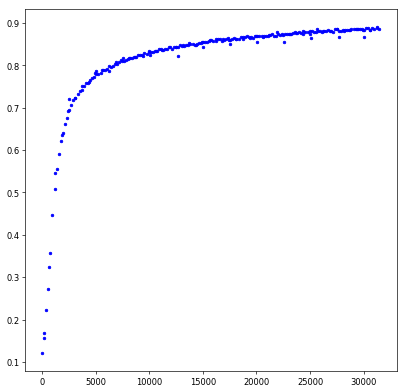

In [88]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(num=1, figsize=(8, 8), dpi=60,
        facecolor='w', edgecolor='k')

for key, value in t_acc_val.items():
    plt.scatter(key, value[0], c='b', marker='.')
plt.show()